# AutoEncoder Model for dataset (Mnist)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import time
import PIL

from IPython import display

In [ ]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [ ]:
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

autoencoder.trainable = False

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

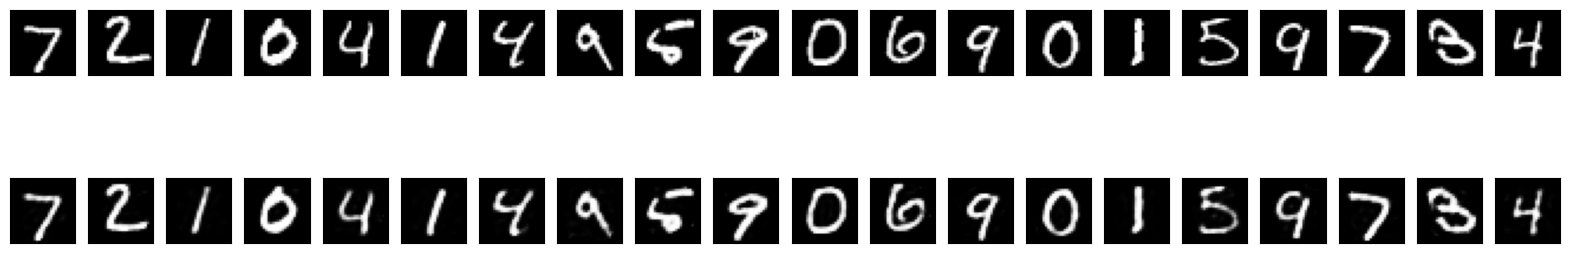

In [ ]:
n = 20
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
train_images = decoded_imgs.reshape(decoded_imgs.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

# SN-GAN (SpectralNormalization for Model Collapse Problem)

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 16

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [ ]:
class SpectralNormalization(tf.keras.layers.Wrapper):
    def __init__(self, layer, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        self.layer.build(input_shape)
        self.w = self.layer.kernel
        self.w_shape = self.w.shape.as_list()
        self.u = self.add_weight(shape=(1, self.w_shape[-1]), initializer=tf.initializers.RandomNormal(0, 1), trainable=False, name="sn_u")
        super(SpectralNormalization, self).build()

    def call(self, inputs):
        self.update_weights()
        output = self.layer(inputs)
        return output

    def update_weights(self):
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        u_hat = self.u
        v_hat = None
        for _ in range(1):
            v_ = tf.matmul(u_hat, tf.transpose(w_reshaped))
            v_hat = tf.nn.l2_normalize(v_)

            u_ = tf.matmul(v_hat, w_reshaped)
            u_hat = tf.nn.l2_normalize(u_)

        sigma = tf.matmul(tf.matmul(v_hat, w_reshaped), tf.transpose(u_hat))
        self.u.assign(u_hat)
        self.layer.kernel.assign(self.w / sigma)


In [ ]:
def generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense((7*7*256), use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # 12544

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128) # 6272
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64) #12544
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)  # 784

  return model

In [ ]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(SpectralNormalization(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1])))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(SpectralNormalization(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(SpectralNormalization(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(SpectralNormalization(layers.Dense(1)))

    return model

In [ ]:
generator = generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
discriminator = discriminator_model()
decision = discriminator(generated_image)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss

  return total_loss

In [ ]:
flatten_layer = discriminator.layers[9]
flatten_layer

In [ ]:
# FeatureMatching Optimization Loss
def generator_loss(real_images, generated_images):
  real_features = flatten_layer(real_images)
  generated_features = flatten_layer(generated_images)

  plt.imshow(generated_features[0, :, :, 0], cmap='gray')
  plt.imshow(real_features[0, :, :, 0], cmap='gray')

  fm_loss = tf.reduce_mean(tf.square(real_features - generated_features))

  return fm_loss

# def generator_loss(fake_output, feature_loss):
#   loss = cross_entropy(tf.ones_like(fake_output), fake_output) + feature_loss

#   return loss

In [ ]:
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
EPOCHS = 300
noise_dim = 100

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    # feature_loss = calculate_feature_loss(images, generated_images)

    # gen_loss = generator_loss(fake_output, feature_loss)
    gen_loss = generator_loss(images, generated_images)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape. gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  # return feature_loss, gen_loss, disc_loss

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    print(f'Time for epoch {epoch+1}')

    for image_batch in dataset:
      train_step(image_batch)
      # fl, gl, dl = train_step(image_batch)
      # loss_values = {'FeatureLoss':fl,
      #                'GeneratorLoss':gl,
      #                'DiscriminatorLoss':dl}
      # print(loss_values)

    generated_images = generator.predict(np.random.normal(size=(5, noise_dim)))
    gen_images = np.clip(generated_images, 0, 1)

    # for z in generated_images:
    #   plt.imshow(z[:,:,0], cmap='gray')
    #   plt.show()

In [ ]:
train(train_dataset, EPOCHS)